In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from tqdm.notebook import tqdm

In [2]:
# Hyper Params
BACKBONE = 'shuffle_net_v2' # shuffle_net_v2, resnet18, mobilenet_v2, xception
MODEL_SAVE_PATH = './Model/' + BACKBONE + '.pth'
BATCH_SIZE = 128
LEARNING_RATE = 0.0005
SCHEDULER_STEPS = 7
SCHEDULER_GAMMA = 0.2
BETAS = (0.9, 0.99)
EPOCHS = 20
QUANTIZE = False

# Transform
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Dataset & Dataloader
data_path = './Data/birds/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), transform[x]) for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

classes = image_datasets['train'].classes

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using Device: {torch.cuda.get_device_name() if torch.cuda.is_available() else "CPU"}')

Using Device: NVIDIA GeForce RTX 3070 Ti


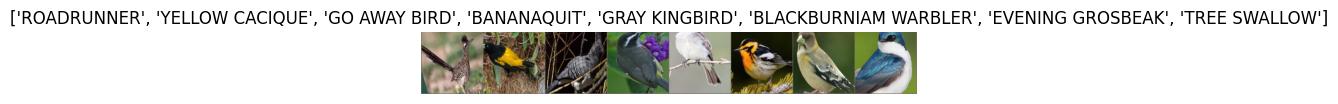

In [3]:
# Preview Data
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


inputs_, labels_ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs_[:8])

imshow(out, title=[classes[x] for x in labels_[:8]])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    train_accuracy = []
    valid_losses = []
    valid_accuracy = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            current = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                current += len(labels)
                if current % 500 == 0 or current == dataset_sizes[phase]:
                    print(f"{phase}:{current}/{dataset_sizes[phase]}")

                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'valid':
                valid_losses.append(epoch_loss)
                valid_accuracy.append(epoch_acc.item())
            else:
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc.item())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    plt.subplot(121)
    plt.plot(valid_accuracy)
    plt.plot(train_accuracy)
    plt.legend(['VAL - ACC', 'TRAIN - ACC'])
    plt.xlabel('EPOCH')
    plt.ylabel('%')
    plt.subplot(122)
    plt.plot(valid_losses)
    plt.plot(train_losses)
    plt.legend(['VAL - LOSS', 'TRAIN - LOSS'])
    plt.xlabel('EPOCH')
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
if not QUANTIZE:
    if BACKBONE == 'shuffle_net_v2':
        model = models.shufflenet_v2_x1_5(weights=models.ShuffleNet_V2_X1_5_Weights.IMAGENET1K_V1)
    elif BACKBONE == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    elif BACKBONE == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
    elif BACKBONE == 'xception':
        model = timm.create_model('xception', pretrained=True, num_classes=450)
        config = resolve_data_config({}, model=model)
        transform['train'] = create_transform(**config)
        transform['valid'] = create_transform(**config)

else:
    if BACKBONE == 'shuffle_net_v2':
        model = models.quantization.shufflenet_v2_x1_5(weights=models.ShuffleNet_V2_X1_5_Weights.IMAGENET1K_V1, progress=True, quantize=False)
    elif BACKBONE == 'resnet18':
        model = models.quantization.resnet18(weights=models.ResNet_Weights.IMAGENET1K_V1, progress=True, quantize=False)
print(model)
if BACKBONE in ['shuffle_net_v2', 'resnet18']:
    num_features = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_features, 450), nn.Softmax(dim=1))
elif BACKBONE == 'mobilenet_v2':
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(nn.Linear(num_features, 450), nn.Softmax(dim=1))

if QUANTIZE:
    model.train()
    model.fuse_model()
    model.qconfig = torch.quantization.default_qat_qconfig
    model = torch.quantization.prepare_qat(model, inplace=True)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=BETAS)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEPS, gamma=SCHEDULER_GAMMA)
print(f'Num Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M')
print(model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_

Epoch 0/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.6252 Acc: 0.5429


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.2694 Acc: 0.8778

Epoch 1/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.2541 Acc: 0.8885


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.2013 Acc: 0.9356

Epoch 2/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.2046 Acc: 0.9266


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1736 Acc: 0.9542

Epoch 3/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1856 Acc: 0.9408


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1699 Acc: 0.9564

Epoch 4/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1754 Acc: 0.9481


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1633 Acc: 0.9578

Epoch 5/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1662 Acc: 0.9560


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1602 Acc: 0.9613

Epoch 6/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1605 Acc: 0.9604


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1527 Acc: 0.9702

Epoch 7/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1434 Acc: 0.9740


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1424 Acc: 0.9760

Epoch 8/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1378 Acc: 0.9782


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1412 Acc: 0.9773

Epoch 9/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1353 Acc: 0.9805


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1385 Acc: 0.9791

Epoch 10/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1338 Acc: 0.9814


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1369 Acc: 0.9822

Epoch 11/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1322 Acc: 0.9830


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1379 Acc: 0.9809

Epoch 12/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1310 Acc: 0.9841


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1382 Acc: 0.9796

Epoch 13/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1301 Acc: 0.9848


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1381 Acc: 0.9796

Epoch 14/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1287 Acc: 0.9857


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1368 Acc: 0.9818

Epoch 15/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1279 Acc: 0.9864


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1364 Acc: 0.9818

Epoch 16/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1276 Acc: 0.9866


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1354 Acc: 0.9827

Epoch 17/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1274 Acc: 0.9868


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1347 Acc: 0.9836

Epoch 18/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1271 Acc: 0.9870


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1353 Acc: 0.9818

Epoch 19/19
----------


  0%|          | 0/552 [00:00<?, ?it/s]

train:16000/70626
train:32000/70626
train:48000/70626
train:64000/70626
train:70626/70626
train Loss: 5.1270 Acc: 0.9870


  0%|          | 0/18 [00:00<?, ?it/s]

valid:2250/2250
valid Loss: 5.1351 Acc: 0.9827

Training complete in 57m 55s
Best val Acc: 0.983556


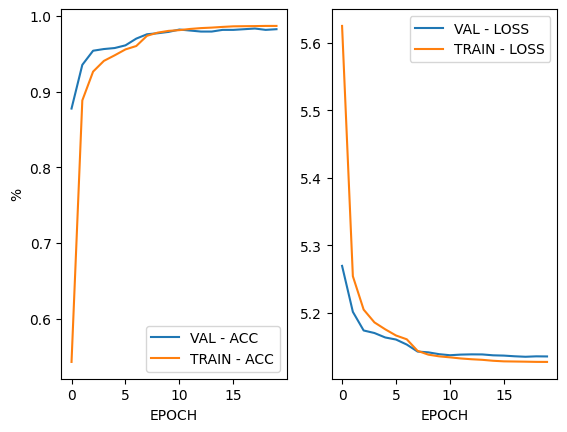

In [6]:
# Enable cuDNN
torch.backends.cudnn.benchmark = True

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

In [7]:
if QUANTIZE:
    from torch.quantization import convert
    model.cpu()
    model_quantized = convert(model, inplace=False)
    torch.save(model_quantized.state_dict(), MODEL_SAVE_PATH)
    print("Model Quantized")
    print("Size: %.2f MB" %(os.path.getsize(MODEL_SAVE_PATH)/1e6))
else:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [16]:
from timeit import default_timer as timer

test_dataset = datasets.ImageFolder('./Data/birds/test/', transform=transform['valid'])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=320)
model.eval()

print('Start Test')
print('-' * 10)
def test():
    correct_f1 = 0
    correct_f5 = 0  # initialize counter for top-5 accuracy
    since = timer()
    with torch.no_grad():
        for data, label in test_dataloader:
            data, label = data.to(DEVICE), label.to(DEVICE)
            output = model(data)
            _, predictions = torch.topk(output, k=5, dim=1)  # get top-5 predicted classes
            correct_f1 += torch.sum(predictions[:, 0] == label.data)  # check if true label is in top-1 predictions
            correct_f5 += torch.sum(predictions == label.unsqueeze(1), dim=1).sum()  # check if true label is in top-5 predictions
    finished = timer()
    print(f'Test Finished With Corrects: {correct_f1}/{len(test_dataset)} | Acc-F1: {correct_f1/len(test_dataset):.3f}')
    print(f'Corrects in Top-5 Predictions: {correct_f5}/{len(test_dataset)} | Acc-F5: {correct_f5/len(test_dataset):.3f}')
    print(f'Time Elapsed: {finished - since:.3f}s | Speed: {len(test_dataset)/(finished - since):.1f}images/s')

test()

Start Test
----------
Test Finished With Corrects: 2227/2250 | Acc-F1: 0.990
Corrects in Top-5 Predictions: 2244/2250 | Acc-F5: 0.997
Time Elapsed: 2.865s | Speed: 785.3images/s
